## 0.0 Python library設定

In [1]:
from IPython.display import Image
import numpy as np
import sys, os

import cntk as C
C.cntk_py.set_fixed_random_seed(1) # fix the random seed so that LR examples are repeatable

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

## 0.1 実施すること

- 年齢(歳)とTumor(腫瘍の大きさ)から、患者が癌かどうかを判定(2値分類)

In [2]:
# Figure 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

- イメージ的にはこんな分類境界(緑色の線)を引きたい

In [3]:
# Figure 2
Image(url= "https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400)

## 1.0 データ生成

In [4]:
## 入力変数(年齢, 腫瘍の大きさ)の2種類あり
input_dim = 2

## 分類数(疾患の有無なので2値)
num_output_classes = 2

In [5]:
## For reproductivity
np.random.seed(0)

## サンプル生成
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    '''
    引数
        sample_size: レコード数　　←被験者数
        feature_dim: 特徴量の次元　←年齢、腫瘍の大きさの2
        num_classes: 分類数　　　　←疾患の有無で2
    Return
        X: 説明変数　←年齢、腫瘍の大きさ（後続処理用に型変換）
        Y: 目的変数　←疾患の有無（1-hotベクトルに変換）
    '''
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable 
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    
    # Specify the data type to match the input variable used later in the tutorial 
    # (default type is double)
    X = X.astype(np.float32)
    
    # convert class 0 into the vector "1 0 0", 
    # class 1 into the vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y

In [6]:
## 可視化用のレコード数
mysamplesize = 32
## データ生成
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)

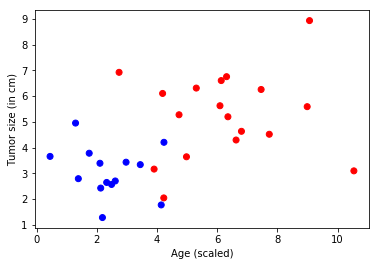

In [7]:
## 非疾患(0)なら青,疾患(1)なら赤 
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

## 2.1 入力・出力変数の定義

In [8]:
## 入力変数
feature = C.input_variable(input_dim, np.float32)

In [9]:
## 出力変数
output_dim = num_output_classes
label = C.input_variable(num_output_classes, np.float32)

## 2.2 モデル構造を定義

In [10]:
## Define a dictionary to store the model parameters
mydict = {}
def linear_layer(input_var, output_dim):
    '''
    引数
        input_var:  入力変数
        output_dim: アウトプットの次元(疾患の有無で2次元)
    Return
        推定式(Wx + b)のCNTKオブジェクト
    '''
    input_dim = input_var.shape[0]
    weight_param = C.parameter(shape=(input_dim, output_dim))
    bias_param = C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param

    return C.times(input_var, weight_param) + bias_param

In [11]:
## モデル構造の定義
z = linear_layer(feature, output_dim)

## 2.3 損失関数、最適化方法の定義

In [12]:
## 損失関数
loss = C.cross_entropy_with_softmax(z, label)
## 分類エラー("分類として"当たっているか否か)
eval_error  = C.classification_error(z, label)

In [13]:
## 学習の速度
learning_rate = 0.5

## 損失関数、最適化方法の定義 
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch) 
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

## 2.4 モデル学習

通常、深層学習は学習時間が長いため、学習の途中の状況を確認することが一般的.

（でないと、例えば学習に数日かかって、凡ミスに気づいて再実行、、なんてことが、、、）

In [14]:
## 学習の進捗度を標準出力
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

- 学習用の全レコード数: `20000`
- 1度の最適化で投入するサンプル数: `25`
  - `20000/25 = 800` 回誤差を縮める(=1 epoch)

In [15]:
## 学習時のサンプル数などを設定
num_samples_to_train = 20000 ## Trainingに利用する全サンプル数
minibatch_size = 25 ## 1度の最適化で投入するサンプル数
num_minibatches_to_train = int(num_samples_to_train  / minibatch_size)

In [16]:
## 進捗度合いを表示頻度を設定
training_progress_output_freq = 50

## 学習
for i in range(0, num_minibatches_to_train):
    ## Extract training data
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    ## Train
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)

Minibatch: 0, Loss: 0.6931, Error: 0.32
Minibatch: 50, Loss: 0.1884, Error: 0.08
Minibatch: 100, Loss: 0.4162, Error: 0.12
Minibatch: 150, Loss: 0.7879, Error: 0.40
Minibatch: 200, Loss: 0.1258, Error: 0.04
Minibatch: 250, Loss: 0.1313, Error: 0.08
Minibatch: 300, Loss: 0.1012, Error: 0.04
Minibatch: 350, Loss: 0.1068, Error: 0.04
Minibatch: 400, Loss: 0.3083, Error: 0.08
Minibatch: 450, Loss: 0.3212, Error: 0.12
Minibatch: 500, Loss: 0.4140, Error: 0.20
Minibatch: 550, Loss: 0.6808, Error: 0.20
Minibatch: 600, Loss: 0.2979, Error: 0.12
Minibatch: 650, Loss: 0.1675, Error: 0.12
Minibatch: 700, Loss: 0.2769, Error: 0.12
Minibatch: 750, Loss: 0.2308, Error: 0.04


## 2.5 モデル評価

In [17]:
out = C.softmax(z)
result = out.eval({feature : features})

In [18]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(x) for x in result])

Label    : [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0]
Predicted: [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]


[[-0.76800036  0.76800036]
 [-0.7891066   0.789107  ]]
[ 7.986333  -7.9863334]


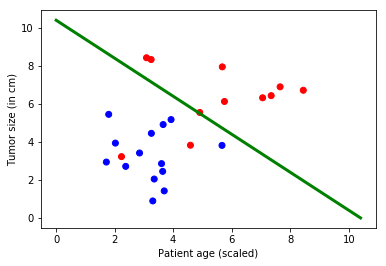

In [19]:
# Model parameters
print(mydict['w'].value)
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# let 0 represent malignant/red, and 1 represent benign/blue
## 非罹患()
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Patient age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

In [20]:
label_true = [np.argmax(label) for label in labels]
label_pred = [np.argmax(x) for x in result]

confusion_matrix(label_true, label_pred)

array([[14,  0],
       [ 2,  9]], dtype=int64)